In [67]:
import pandas as pd
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


df = pd.read_csv('final.csv')
df.head()

,id,type,start,end,lat,lon,vessel.id,vessel.type,vessel.mmsi,vessel.name,...,encounter.encountered_vessel.destination_port.name,encounter.encountered_vessel.authorizations.authorized,encounter.encountered_vessel.authorizations.unknown,loitering.total_distance_km,loitering.loitering_hours,port.lat,port.lon,port.country,port.name,date
0,f6f02128e9fb54c8ea1bc7987f8d46d7.1,encounter,2015-02-02 23:40:00 UTC,2015-02-03 05:30:00 UTC,-45.583971,-60.494544,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,RECALADA,NaN,ICCAT|CCSBT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01
1,1193f92e4aa29480fbfa2ace644fa143.1,encounter,2015-05-29 15:30:00 UTC,2015-05-30 08:30:00 UTC,-45.505687,-60.486374,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,PUNTA ARENAS,NaN,ICCAT|CCSBT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01
2,ea7ca74af5300c273a0ce288f129763e.1,encounter,2015-02-19 15:50:00 UTC,2015-02-19 21:40:00 UTC,-45.534999,-60.493174,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,NaN,NaN,ICCAT|CCSBT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01
3,7a6a1688b85b7e12770ed2385dd38656.1,encounter,2015-02-17 15:30:00 UTC,2015-02-17 21:10:00 UTC,-45.554563,-60.497218,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,MONTEVIDEO,NaN,CCSBT|ICCAT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01
4,5489a5c393dafcb70b4f29d0b52786c7.1,encounter,2015-02-15 17:40:00 UTC,2015-02-16 00:20:00 UTC,-45.554497,-60.495039,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,ZHOUSHAN,NaN,CCSBT|ICCAT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01


In [68]:
def count_unknown(s):
    if s == 'NA':
        return 0
    else:
        return len(str(s).split('|'))

<AxesSubplot:>

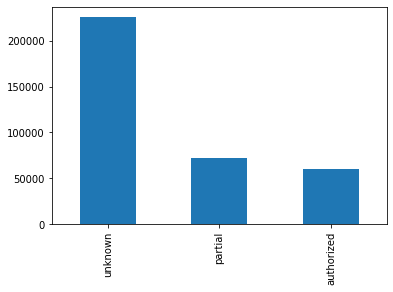

In [69]:
df['encounter.authorization_status'].value_counts().plot(kind='bar')

In [70]:
df['unauthorized_count'] = df['encounter.encountered_vessel.authorizations.unknown'].fillna('NA').apply(count_unknown)


<AxesSubplot:>

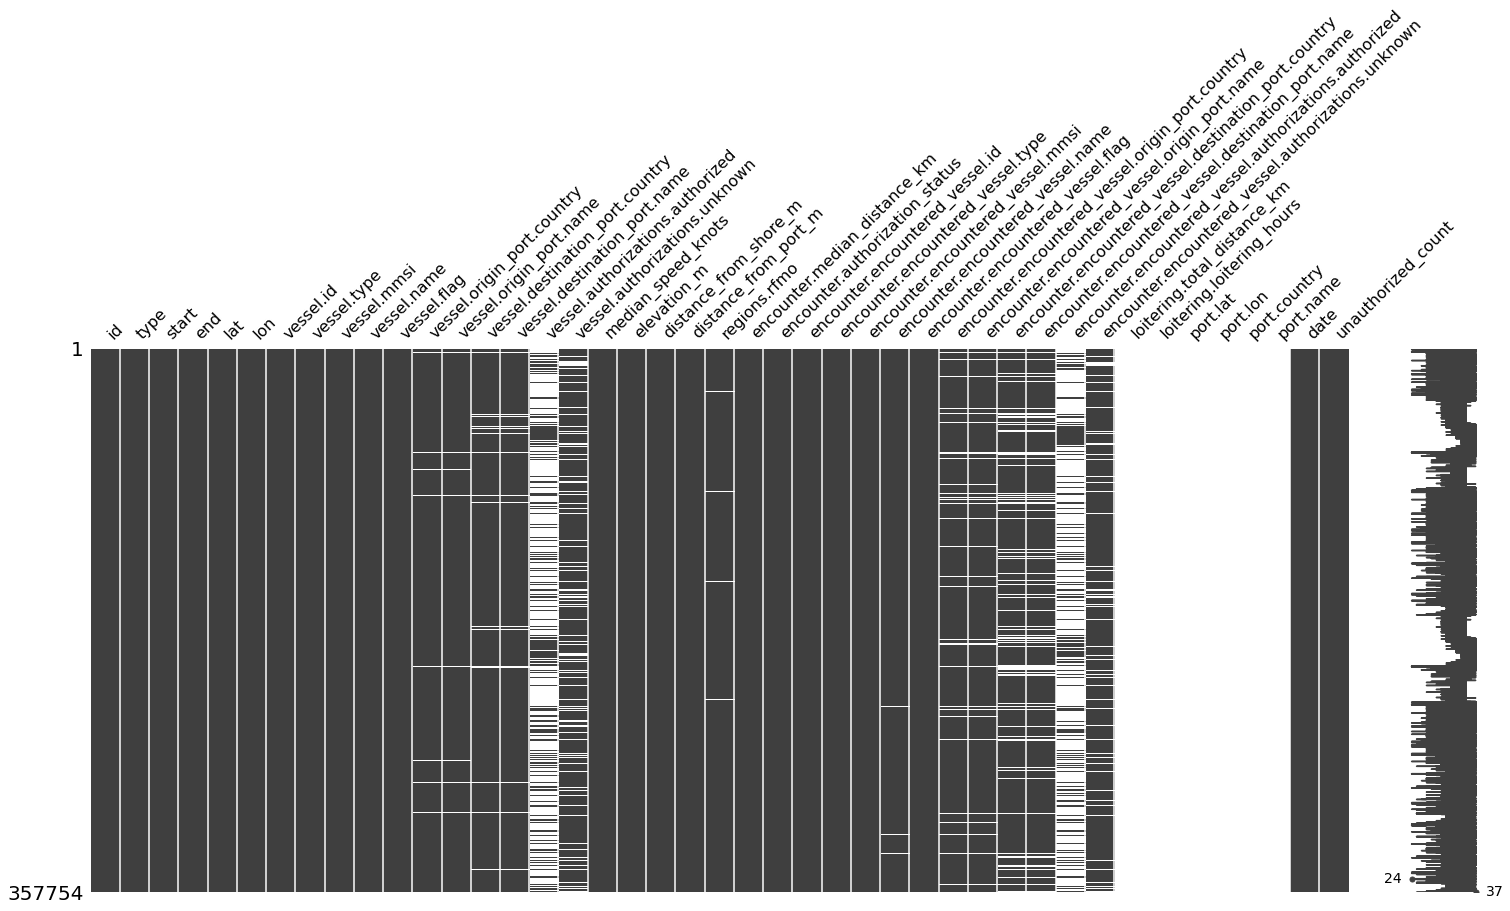

In [71]:
msno.matrix(df)

In [72]:
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])
df['duration'] = (df['end'] - df['start']).dt.seconds /60

In [73]:
df.dtypes

id                                                                     object
type                                                                   object
start                                                     datetime64[ns, UTC]
end                                                       datetime64[ns, UTC]
lat                                                                   float64
lon                                                                   float64
vessel.id                                                              object
vessel.type                                                            object
vessel.mmsi                                                             int64
vessel.name                                                            object
vessel.flag                                                            object
vessel.origin_port.country                                             object
vessel.origin_port.name                                         

In [74]:
df['is_authorized'] = df['encounter.authorization_status'].apply(lambda x: 2 if x == 'authorized' else (1 if x == 'partial' else 0))

In [75]:
df2 = df.sample(100000, random_state=200)
df = df.drop(df2.index)


In [76]:
df.shape

(257754, 45)

In [77]:
df2.shape

(100000, 45)

In [78]:
df = df[['median_speed_knots', 'elevation_m', 'distance_from_shore_m', 'distance_from_port_m', 'encounter.median_distance_km', 'duration', 'is_authorized']]
df

,median_speed_knots,elevation_m,distance_from_shore_m,distance_from_port_m,encounter.median_distance_km,duration,is_authorized
0,0.028,-105,396000,417048.781,0.052,350.0,0
2,0.019,-101,394000,416120.438,0.037,350.0,0
3,0.041,-90,394000,415715.250,0.049,340.0,0
4,0.016,-90,394000,415715.250,0.064,400.0,0
7,1.304,-2667,224000,340354.656,0.028,200.0,2
...,...,...,...,...,...,...,...
357748,0.007,-21,1000,17866.998,0.471,220.0,2
357749,0.009,-21,1000,17866.998,0.161,920.0,2
357751,0.010,-45,2000,31134.578,0.011,680.0,2
357752,0.016,-6,1000,57596.129,0.339,950.0,2


In [79]:
df2 = df2[['median_speed_knots', 'elevation_m', 'distance_from_shore_m', 'distance_from_port_m', 'encounter.median_distance_km', 'duration', 'is_authorized']]
df2

,median_speed_knots,elevation_m,distance_from_shore_m,distance_from_port_m,encounter.median_distance_km,duration,is_authorized
334592,0.889,-4322,1511000,2269359.750,0.030,160.0,1
290414,1.581,-205,310000,377846.469,0.021,190.0,0
208622,0.996,-5121,455000,652170.750,0.027,130.0,2
115063,0.027,-9,4000,14665.106,0.044,290.0,0
78234,0.037,-36,37000,125600.766,0.049,770.0,0
...,...,...,...,...,...,...,...
114710,0.297,-148,44000,328748.875,0.041,140.0,0
69281,0.643,-250,89000,104180.633,0.057,400.0,0
28071,0.754,-4085,1335000,2060426.750,0.051,240.0,1
143577,0.010,-210,1000,26736.762,0.277,760.0,2


In [127]:
# Import train_test_split function
#X = df[['median_speed_knots', 'elevation_m', 'distance_from_shore_m', 'distance_from_port_m', 'encounter.median_distance_km', 'duration']]  # Features

X = df[['distance_from_port_m']]  # Features
y = df['is_authorized']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [81]:
X2 = df2[['median_speed_knots', 'elevation_m', 'distance_from_shore_m', 'distance_from_port_m', 'encounter.median_distance_km', 'duration']]  # Features
y2 = df2['is_authorized']  # Labels

# Split dataset into training set and test set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3) # 70% training and 30% test

In [82]:
df.is_authorized.value_counts()

0    162220
1     52252
2     43282
Name: is_authorized, dtype: int64

In [128]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [129]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Training Accuracy = ", clf.score(X_train, y_train))
print("Test Accuracy = ", clf.score(X_test, y_test))

Training Accuracy =  0.9920411024957462
Test Accuracy =  0.9676697660584272


In [131]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

distance_from_port_m    1.0
dtype: float64

In [86]:
df.corr()

,median_speed_knots,elevation_m,distance_from_shore_m,distance_from_port_m,encounter.median_distance_km,duration,is_authorized
median_speed_knots,1.000000,-0.464203,0.424498,0.391164,-0.174488,-0.159261,0.285279
elevation_m,-0.464203,1.000000,-0.715824,-0.671458,0.147066,0.200008,-0.696422
distance_from_shore_m,0.424498,-0.715824,1.000000,0.929361,-0.154182,-0.205048,0.501678
distance_from_port_m,0.391164,-0.671458,0.929361,1.000000,-0.158212,-0.188242,0.471544
encounter.median_distance_km,-0.174488,0.147066,-0.154182,-0.158212,1.000000,-0.046001,-0.002999
duration,-0.159261,0.200008,-0.205048,-0.188242,-0.046001,1.000000,-0.168184
is_authorized,0.285279,-0.696422,0.501678,0.471544,-0.002999,-0.168184,1.000000


<AxesSubplot:xlabel='distance_from_shore_m', ylabel='elevation_m'>

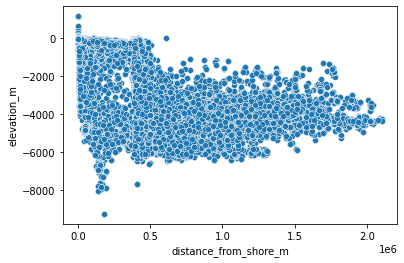

In [87]:
import seaborn as sns
import numpy as np
sns.scatterplot(x='distance_from_shore_m', y='elevation_m' , data=df)

In [88]:
# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(X_train, y_train)

In [89]:
preds = gnb.predict(X_test2)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test2, preds))

[1 0 0 ... 0 1 0]
0.7665


In [90]:
len(preds)

30000

In [91]:
X_train.value_counts()

median_speed_knots  elevation_m  distance_from_shore_m  distance_from_port_m  encounter.median_distance_km  duration
1.151               -162         174000                 290999.344            0.051                         350.0       10
1.014               -4609        455000                 605138.125            0.027                         490.0       10
1.542               -5224        399000                 434023.219            0.026                         200.0       10
1.621               -3058        587000                 593793.312            0.028                         210.0        9
0.781               -166         43000                  42668.504             0.011                         200.0        9
                                                                                                                        ..
0.675               -211         59000                  312210.969            0.038                         950.0        1
                    -2

In [92]:
y_train.value_counts()

0    113630
1     36636
2     30161
Name: is_authorized, dtype: int64

In [93]:
y_test.value_counts()

0    48590
1    15616
2    13121
Name: is_authorized, dtype: int64

## Random Forest CLassifier

In [94]:
pd.Series(y_pred.tolist()).value_counts()

0    18863
1     6139
2     4998
dtype: int64

## Naive Bayes Classifier

In [95]:
pd.Series(preds.tolist()).value_counts()

0    19159
1     7357
2     3484
dtype: int64

In [104]:
df[df['is_authorized'] == 0]

,median_speed_knots,elevation_m,distance_from_shore_m,distance_from_port_m,encounter.median_distance_km,duration,is_authorized
0,0.028,-105,396000,417048.781,0.052,350.0,0
2,0.019,-101,394000,416120.438,0.037,350.0,0
3,0.041,-90,394000,415715.250,0.049,340.0,0
4,0.016,-90,394000,415715.250,0.064,400.0,0
56,0.232,-316,273000,426831.406,0.041,1300.0,0
57,0.955,-107,35000,126979.047,0.179,320.0,0
59,0.687,-118,49000,146652.078,0.046,500.0,0
62,0.659,-307,308000,432574.906,0.041,1300.0,0
63,0.499,-659,278000,278525.844,0.030,850.0,0
64,0.772,-115,39000,215131.359,0.046,20.0,0


In [105]:
df[df['is_authorized'] == 2][0:10]

,median_speed_knots,elevation_m,distance_from_shore_m,distance_from_port_m,encounter.median_distance_km,duration,is_authorized
7,1.304,-2667,224000,340354.656,0.028,200.0,2
8,1.451,-3414,227000,294973.125,0.021,220.0,2
9,0.985,-2405,283000,625707.688,0.020,140.0,2
11,1.972,-4349,195000,197768.578,0.018,360.0,2
13,1.256,-2592,285000,632825.375,0.023,340.0,2
14,0.641,-4472,290000,420552.438,0.310,130.0,2
16,0.774,-2364,21000,39307.855,0.040,810.0,2
17,1.040,-1880,15000,32919.953,0.042,660.0,2
19,0.462,-1758,15000,32715.656,0.036,920.0,2
21,0.662,-4339,99000,101941.711,0.041,130.0,2


<AxesSubplot:xlabel='is_authorized', ylabel='elevation_m'>

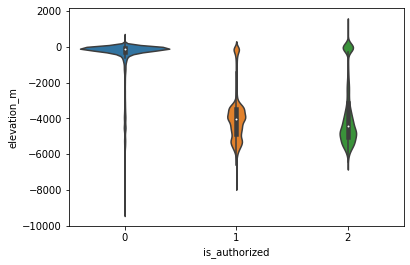

In [106]:
sns.violinplot(x='is_authorized', y='elevation_m', data=df)

<AxesSubplot:xlabel='is_authorized', ylabel='median_speed_knots'>

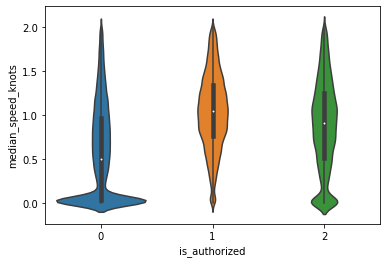

In [139]:
sns.violinplot(x='is_authorized', y='median_speed_knots', data=df)

<AxesSubplot:xlabel='is_authorized', ylabel='distance_from_port_m'>

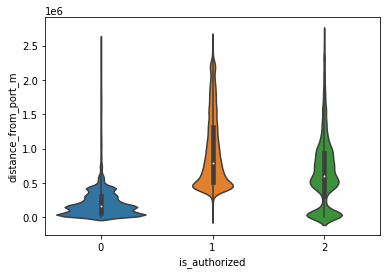

In [130]:
sns.violinplot(x='is_authorized', y='distance_from_port_m', data=df)

<AxesSubplot:xlabel='distance_from_port_m', ylabel='Count'>

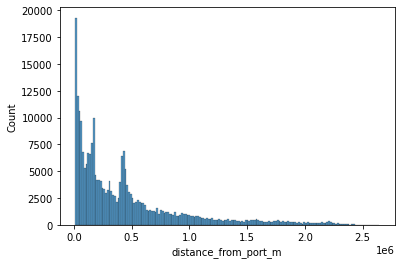

In [138]:
sns.histplot(x='distance_from_port_m', data=df)

<AxesSubplot:xlabel='elevation_m', ylabel='Count'>

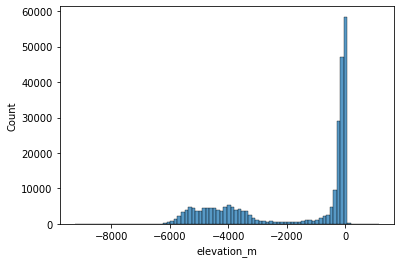

In [141]:
sns.histplot(x='elevation_m', data=df)

In [132]:
df.describe()

,median_speed_knots,elevation_m,distance_from_shore_m,distance_from_port_m,encounter.median_distance_km,duration,is_authorized
count,257754.000000,257754.000000,2.577540e+05,2.577540e+05,257754.000000,257754.000000,257754.000000
mean,0.719821,-1746.981475,3.315082e+05,4.508336e+05,0.055893,455.499042,0.538560
std,0.550642,2099.921840,3.965550e+05,4.849202e+05,0.062299,330.620754,0.764431
min,0.000000,-9243.000000,0.000000e+00,1.000041e+04,0.000000,0.000000,0.000000
25%,0.092000,-3947.000000,2.700000e+04,1.038854e+05,0.029000,200.000000,0.000000
50%,0.729000,-261.000000,1.510000e+05,2.948929e+05,0.041000,340.000000,0.000000
75%,1.135000,-62.000000,4.870000e+05,5.919498e+05,0.055000,630.000000,1.000000
max,2.000000,1155.000000,2.106000e+06,2.645444e+06,0.498000,1430.000000,2.000000
